# PDBe API Training

### PDBe search

This interactive Python notebook will guide you through programmatically accessing Protein Data Bank in Europe (PDBe)
data using our REST API

The REST API is a programmatic way to obtain information from the PDB and EMDB. You can access details about:

* sample
* experiment
* models
* compounds
* cross-references
* publications
* quality
* assemblies
* search
and more...
For more information, visit https://pdbe.org/api


This tutorial will guide you through searching PDBe programmatically.


First we will import the code which will do the work
Run the cell below - by pressing the green play button.

In [17]:
from pprint import pprint
from solrq import Q, Range
import sys
sys.path.insert(0,'..') # to ensure the below import works in all Jupyter notebooks
from python_modules.api_modules import run_search, pandas_dataset, pandas_count, pandas_plot, pandas_plot_multi_groupby

Now we are ready to actually run a search against the PDB API for entries containing human Dihydrofolate reductase in the PDB. This will return a list of results - only 10 to start with.

A list of search terms is available at:
https://www.ebi.ac.uk/pdbe/api/doc/search.html

We are going to search for the molecule name "Dihydrofolate reductase" in the PDB

The search terms are defined using a module called Q

We have imported a function called "run_search" that will do the search for us.
We have limited this to 10 results and we will print finished at the end to show its complete

In [8]:
print('1st search - limited to 10 results')

search_terms = Q(molecule_name='Dihydrofolate reductase')

first_results = run_search(search_terms)
print('finished')

1st search - limited to 10 results
Number of results for molecule_name:Dihydrofolate\ reductase: 10
finished


what if we try to search for something that doesn't exist

In [9]:
print('Getting the search wrong')

search_terms = Q(something_that_does_not_exist="Dihydrofolate reductase")
false_results = run_search(search_terms)

Getting the search wrong
Number of results for something_that_does_not_exist:Dihydrofolate\ reductase: 0


In [10]:
search_terms = Q(molecule_name="bob")
false_results2 = run_search(search_terms)

Number of results for molecule_name:bob: 0


or we define our search terms incorrectly (this will fail)

In [12]:
search_terms = Q('bob')
false_results3 = run_search(search_terms)

AttributeError: 'str' object has no attribute 'compile'

We will add organism_name of Human to the query to limit the results to only return those that are structures of Human Dihydrofolate reductase.

In [13]:
print('2nd search - two terms together')
search_terms = Q(organism_name="Human",molecule_name="Dihydrofolate reductase")
second_results = run_search(search_terms)


2nd search - two terms together
Number of results for organism_name:Human AND molecule_name:Dihydrofolate\ reductase: 10


For more complicated queries have a look at the documentation
https://solrq.readthedocs.io/en/latest/index.html

How did we know which search terms to use?

We will then look at the results of the last search.

We will look at the first result with the following command
i.e. second_results[0]

We are going to use "pprint" (pretty print) rather than "print" to make the result easier to read.

All of the "keys" on the left side of the results can be used as a search term.

In [14]:
pprint(second_results[0])

{'_version_': 1674581818601373696,
 'abstracttext_unassigned': ['Structural data are reported for the first '
                             'examples of the tetrahydroquinazoline antifolate '
                             '(6R,6S)-2,4-diamino-6-(1-indolinomethyl)-5,6,7,8-tetrahydroquinazoline '
                             '(1) and its trimethoxy analogue '
                             "(6R,6S)-2,4-diamino-6-(3',4',5'-trimethoxybenzyl)-5,6,7,8-tetrahydroquinazoline "
                             '(2) as inhibitor complexes with dihydrofolate '
                             'reductase (DHFR) from human (hDHFR) and '
                             'Pneumocystis carinii (pcDHFR) sources. The '
                             'indoline analogue (1) was crystallized as '
                             'ternary complexes with NADPH and hDHFR (1.9 A '
                             'resolution) and pcDHFR (2.3 A resolution), while '
                             'the trimethoxy quinazoline analogue (2) wa

We use terms prefixed with q_ and t_ for our internal use so we can exclude the
 list of available search terms is available using the following command and then see how many search terms there are

In [8]:
keys_without_q = [q for q in second_results[0].keys() if not (q.startswith('q_') or (q.startswith('t_')))]
print('There are {} available search terms'.format(len(keys_without_q)))

There are 212 available search terms


and then print out the terms we can use

In [9]:
pprint(keys_without_q)

['abstracttext_unassigned',
 'all_assembly_composition',
 'all_assembly_form',
 'all_assembly_id',
 'all_assembly_mol_wt',
 'all_assembly_type',
 'all_authors',
 'all_molecule_names',
 'all_num_interacting_entity_id',
 'assembly_composition',
 'assembly_form',
 'assembly_id',
 'assembly_mol_wt',
 'assembly_num_component',
 'assembly_type',
 'beam_source_name',
 'biological_cell_component',
 'all_go_terms',
 'biological_function',
 'biological_process',
 'bound_compound_id',
 'bound_compound_name',
 'bound_compound_synonym',
 'bound_compound_systematic_name',
 'bound_compound_weight',
 'cath_architecture',
 'all_structure_family',
 'cath_class',
 'cath_code',
 'cath_homologous_superfamily',
 'cath_topology',
 'cell_a',
 'cell_alpha',
 'cell_b',
 'cell_beta',
 'cell_c',
 'cell_gamma',
 'citation_authors',
 'citation_doi',
 'citation_title',
 'citation_year',
 'cofactor_class',
 'cofactor_id',
 'compound_id',
 'compound_name',
 'all_compound_names',
 'compound_synonym',
 'compound_systema

As you can see we get lots of data back about the individual molecule we have searched for and the PDB entries
in which it is contained.

We can get the PDB ID and experimental method for this first result as follows.

In [10]:
print(second_results[0].get('pdb_id'))
print(second_results[0].get('experimental_method'))

4kak
['X-ray diffraction']


Note that the experimental method is a list as there can be more than one experimental method per entry

There are too many different terms to look through so we can restrict the results to only the information we want
using a filter so its easier to see the information we want.

In [15]:
print('3rd search')
search_terms = Q(molecule_name="Dihydrofolate reductase",organism_name="Human")
filter_terms = ['pdb_id', 'experimental_method']
third_results = run_search(search_terms, filter_terms)
pprint(third_results)

3rd search
Number of results for molecule_name:Dihydrofolate\ reductase AND organism_name:Human: 10
[{'experimental_method': ['X-ray diffraction'], 'pdb_id': '1s3v'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '4keb'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '3fs6'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '3l3r'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '5hqz'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '1s3u'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '6de4'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '3nxy'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '1mvs'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '3s7a'}]


We are still restricting the number of entries to 10 so we get the results quickly

We will then increase the number of rows to 1000 - depending on the search we might get fewer than 1000 results back

In [16]:
print('Search with 1000 rows')
search_terms = Q(molecule_name="Dihydrofolate reductase",organism_name="Human")
filter_terms = ['pdb_id', 'experimental_method', 'release_year']

third_results_more_rows = run_search(search_terms, filter_terms, number_of_rows=1000)
pprint(third_results_more_rows)

Search with 1000 rows
Number of results for molecule_name:Dihydrofolate\ reductase AND organism_name:Human: 79
[{'experimental_method': ['X-ray diffraction'],
  'pdb_id': '1s3v',
  'release_year': 2004},
 {'experimental_method': ['X-ray diffraction'],
  'pdb_id': '4keb',
  'release_year': 2013},
 {'experimental_method': ['X-ray diffraction'],
  'pdb_id': '3fs6',
  'release_year': 2009},
 {'experimental_method': ['X-ray diffraction'],
  'pdb_id': '3l3r',
  'release_year': 2011},
 {'experimental_method': ['X-ray diffraction'],
  'pdb_id': '5hqz',
  'release_year': 2017},
 {'experimental_method': ['X-ray diffraction'],
  'pdb_id': '1s3u',
  'release_year': 2004},
 {'experimental_method': ['X-ray diffraction'],
  'pdb_id': '6de4',
  'release_year': 2018},
 {'experimental_method': ['X-ray diffraction'],
  'pdb_id': '3nxy',
  'release_year': 2010},
 {'experimental_method': ['X-ray diffraction'],
  'pdb_id': '1mvs',
  'release_year': 2003},
 {'experimental_method': ['X-ray diffraction'],
  'p

We are going to use a Python package called Pandas to help us analyse and visualise the results

In [3]:
df = pandas_dataset(list_of_results=third_results_more_rows)
print(df)

   experimental_method pdb_id  release_year
0    X-ray diffraction   4kak          2013
1    X-ray diffraction   5hve          2017
2    X-ray diffraction   2w3a          2009
3    X-ray diffraction   6a7c          2019
4    X-ray diffraction   3eig          2009
..                 ...    ...           ...
74   X-ray diffraction   6de4          2018
75   X-ray diffraction   1ohk          1998
76   X-ray diffraction   1pd9          2003
77   X-ray diffraction   1drf          1992
78   X-ray diffraction   4ddr          2012

[79 rows x 3 columns]


We can save the results to a CSV file which we can load into excel

In [ ]:
df.to_csv("search_results.csv")

We can use the this to count how many PDB codes there are for each experimental method
This groups PDB IDs by experimental method and then counts the number of unique PDB IDs per method.

In [4]:
pandas_count(df=df,
             column_to_group_by='experimental_method')

experimental_method
Solution NMR          1
X-ray diffraction    78
Name: pdb_id, dtype: int64

or plot the results

In [5]:
pandas_plot(df=df,
            column_to_group_by='experimental_method',
            graph_type='bar'
            )

or plot per release year

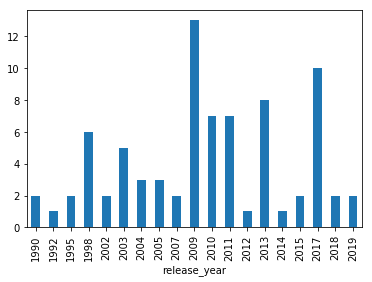

In [6]:
pandas_plot(df=df,
            column_to_group_by='release_year',
            graph_type='bar'
            )

maybe a line plot makes more sense here

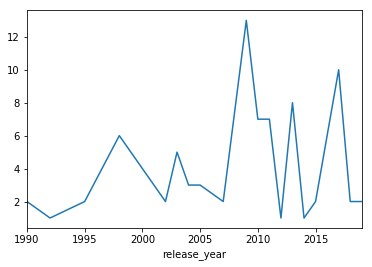

In [7]:
pandas_plot(df=df,
            column_to_group_by='release_year',
            graph_type='line'
            )

Maybe we've heard that Electron Microscopy is taking over and we want to see if this is true

We will filter out all hybrid methods.

Number of results for release_year:[2000 TO 2019]: 100


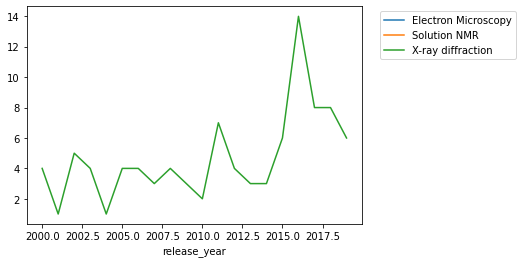

In [19]:
search_terms = Q(release_year=Range(2000, 2019))
filter_results = ['experimental_method','release_year', 'pdb_id']
results = run_search(search_terms, filter_results, number_of_rows=100)

df = pandas_dataset(results)

# filter out all hybrid methods
df = df[~df['experimental_method'].str.contains(',')]
pandas_plot_multi_groupby(df, 'release_year', 'experimental_method')

To get the full list of results we need to increase the number of results we get back

The third line filters out all hybrid methods which makes the graph easier to see.

In [ ]:
results = run_search(search_terms, filter_results, number_of_rows=100000)
# filter out all hybrid methods
df = pandas_dataset(results)
df = df[~df['experimental_method'].str.contains(',')]
pandas_plot_multi_groupby(df, 'release_year', 'experimental_method')